# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
import torch
import transformers
import spacy
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import logging
import math
from tqdm.auto import tqdm

tqdm.pandas()



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Análisis exploratorio 

In [5]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [6]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
23036,tt0119718,movie,Mr. Magoo,Mr. Magoo,1997,\N,87,0,"Adventure,Comedy,Family",4.0,13974,After seeing this film I felt sick to my stoma...,1,neg,0,test,11309
23620,tt0132347,movie,Mystery Men,Mystery Men,1999,\N,121,0,"Action,Comedy,Fantasy",6.1,60777,A lot of the user comments i have seen on the ...,7,pos,1,train,6673
5619,tt0144120,movie,Bride of Chucky,Bride of Chucky,1998,\N,89,0,"Comedy,Horror",5.4,50864,"I know this movie isn't for everyone, and I wo...",10,pos,1,test,4219
35491,tt0078966,movie,The China Syndrome,The China Syndrome,1979,\N,122,0,"Drama,Thriller",7.4,26143,"""The China Syndrome"" launched a whole string o...",7,pos,1,test,8450
3670,tt0380201,movie,Back in the Day,Back in the Day,2005,\N,103,0,"Action,Crime,Drama",4.5,701,I watched this movie out of a lack of anything...,7,pos,1,test,3873
34866,tt0069811,movie,The Body Shop,The Body Shop,1972,\N,75,0,"Horror,Sci-Fi",3.6,385,**Spoiler* It gives away the very irrelevant e...,2,neg,0,test,9462
10837,tt0367677,movie,Dracula 3000,Dracula 3000,2004,\N,86,0,"Horror,Sci-Fi",2.1,5880,This is my first comment on a movie in here. I...,1,neg,0,test,2000
31142,tt0240900,movie,Slackers,Slackers,2002,\N,86,0,"Comedy,Romance",5.4,13605,This film looked promising but it was actually...,3,neg,0,train,9073
7988,tt0337945,movie,Coronado,Coronado,2003,\N,88,0,"Action,Adventure,Comedy",4.4,1472,Another awful movie from Hollywood. This time ...,2,neg,0,test,4792
11149,tt0815744,tvMiniSeries,DumbLand,DumbLand,2002,2002,35,0,"Animation,Comedy,Short",6.4,2614,"This is a short, crudely animated series by Da...",7,pos,1,train,5735


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews['end_year'].value_counts()

\N      45052
2007      225
2008      190
2006      140
2009      130
2010      124
2003      102
2002       97
2005       96
1996       96
2004       84
2001       75
1995       69
1999       61
1983       55
1989       49
2012       47
1985       40
2000       40
1976       37
1987       35
1994       34
1986       33
2017       32
1998       27
1990       26
2011       22
1982       21
2013       19
2014       17
1975       17
1984       16
1997       16
1981       16
1960       16
1973       15
1979       15
1988       14
1991       14
1993       13
1977       10
1978        9
1974        7
1972        7
1965        7
1970        7
1961        6
1969        6
2020        6
1957        5
1980        5
2016        5
1955        4
2018        4
2019        4
1966        4
1962        3
1953        2
1968        2
1959        1
Name: end_year, dtype: int64

In [9]:
df_reviews[['pos','start_year','is_adult','average_rating','votes','rating','idx']].corr()

,pos,start_year,is_adult,average_rating,votes,rating,idx
pos,1.000000,-0.181571,0.005168,0.481103,0.052365,0.941231,0.005141
start_year,-0.181571,1.000000,-0.008444,-0.189847,0.095835,-0.187441,-0.002162
is_adult,0.005168,-0.008444,1.000000,-0.015592,-0.012193,0.004866,-0.017616
average_rating,0.481103,-0.189847,-0.015592,1.000000,0.229570,0.509180,-0.019296
votes,0.052365,0.095835,-0.012193,0.229570,1.000000,0.054170,-0.014679
rating,0.941231,-0.187441,0.004866,0.509180,0.054170,1.000000,0.000956
idx,0.005141,-0.002162,-0.017616,-0.019296,-0.014679,0.000956,1.000000


In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

No encontramos mayor problema con los datos. Nuestra variable objetivo parace estar bien distribuida, no hay duplicados, hay algunos valores NAN que veremos si son relevantes o no para nuestro objetivo más adelante. Solo vemos correlación para 'pos' entre rating y average rating. 

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

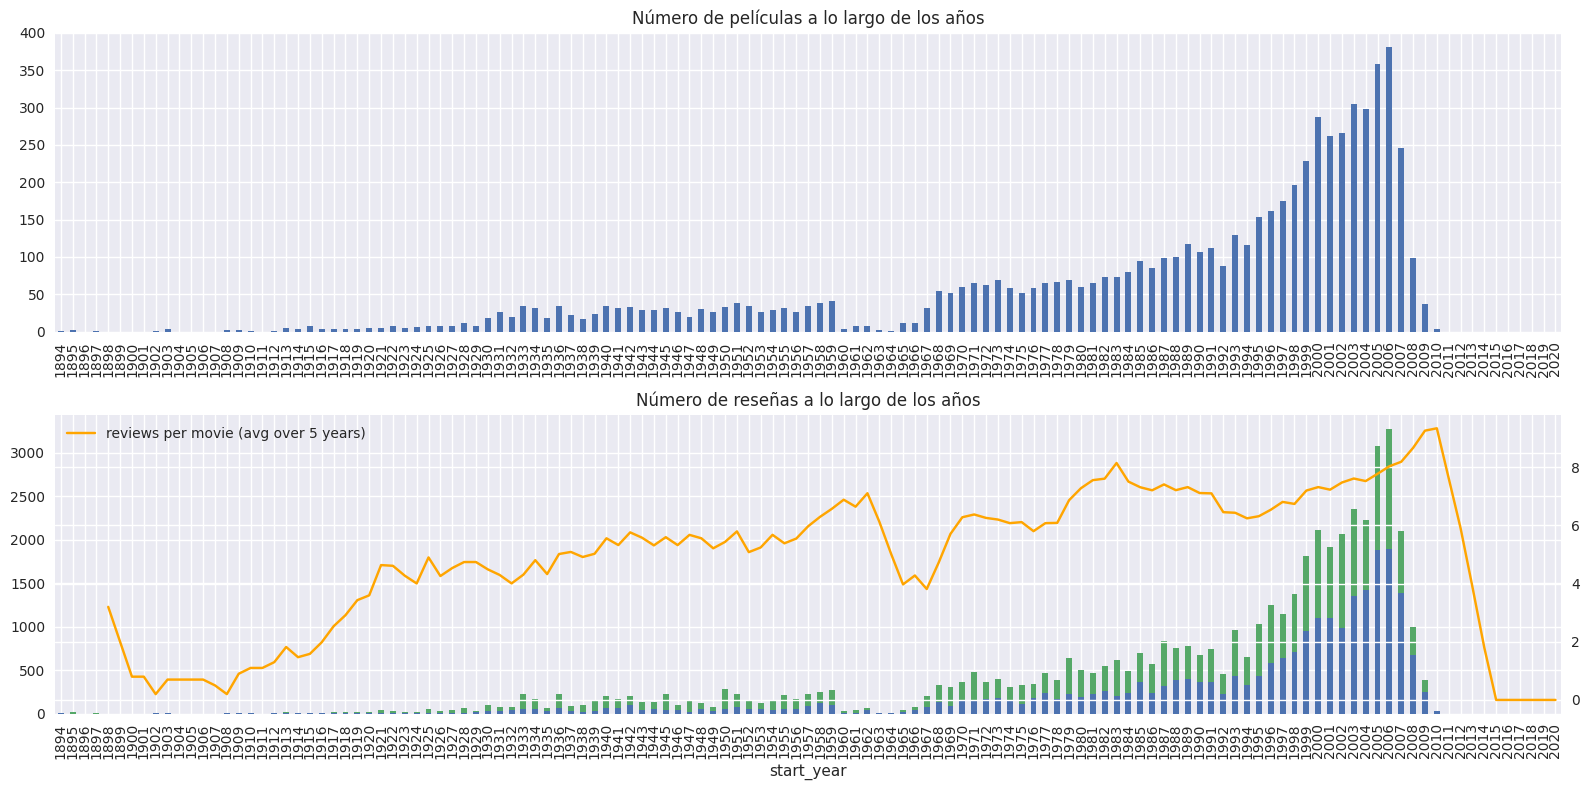

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto, la linea de tendencia a lo largo de los años y la distribución de reseñas positivas y negativas a traves del tiempo. Al haber más peliculas tambien hay más reseñas. 

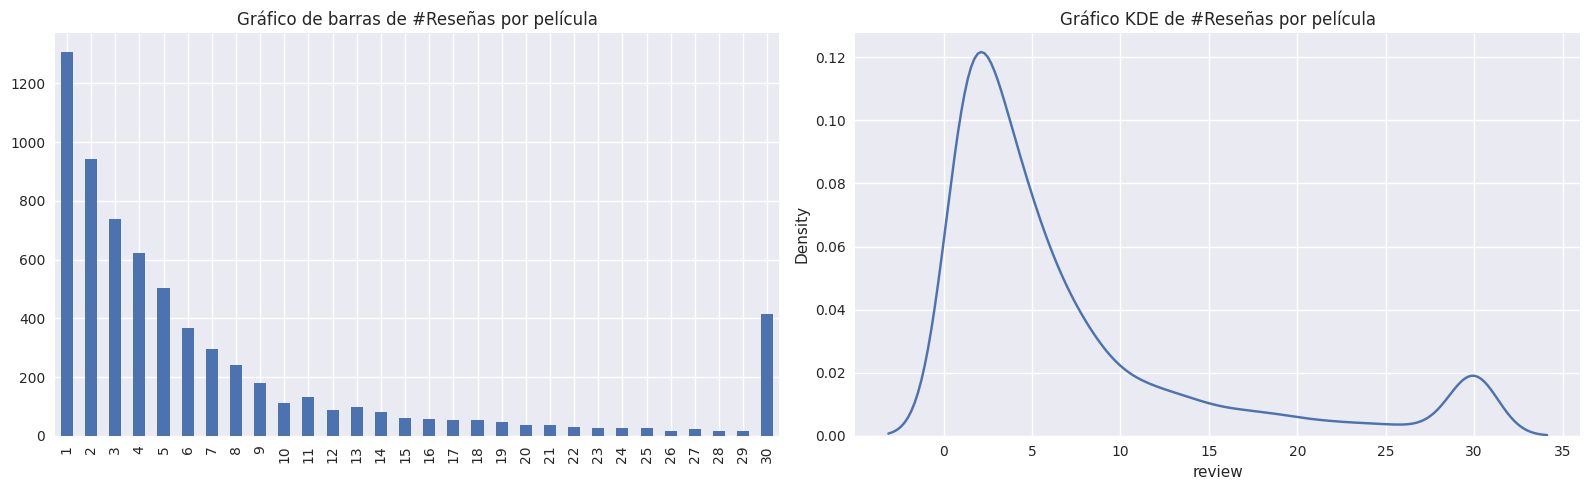

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Vemos que en promedio un máximo de 30 reseñas se dejan por peliculas, sienda la tendencia entre 1 y 8. No sabemos si es una limitante de la plataforma o si en realidad es el máximo de reseñas que dejan las personas.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

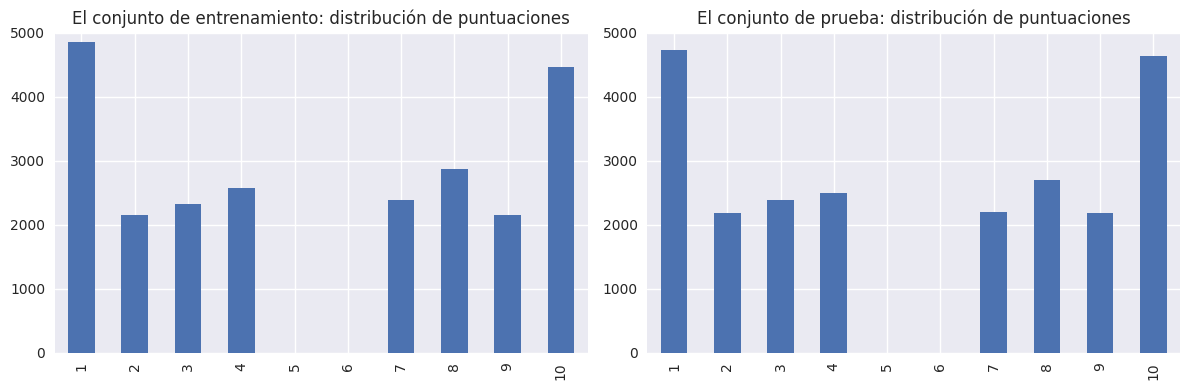

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


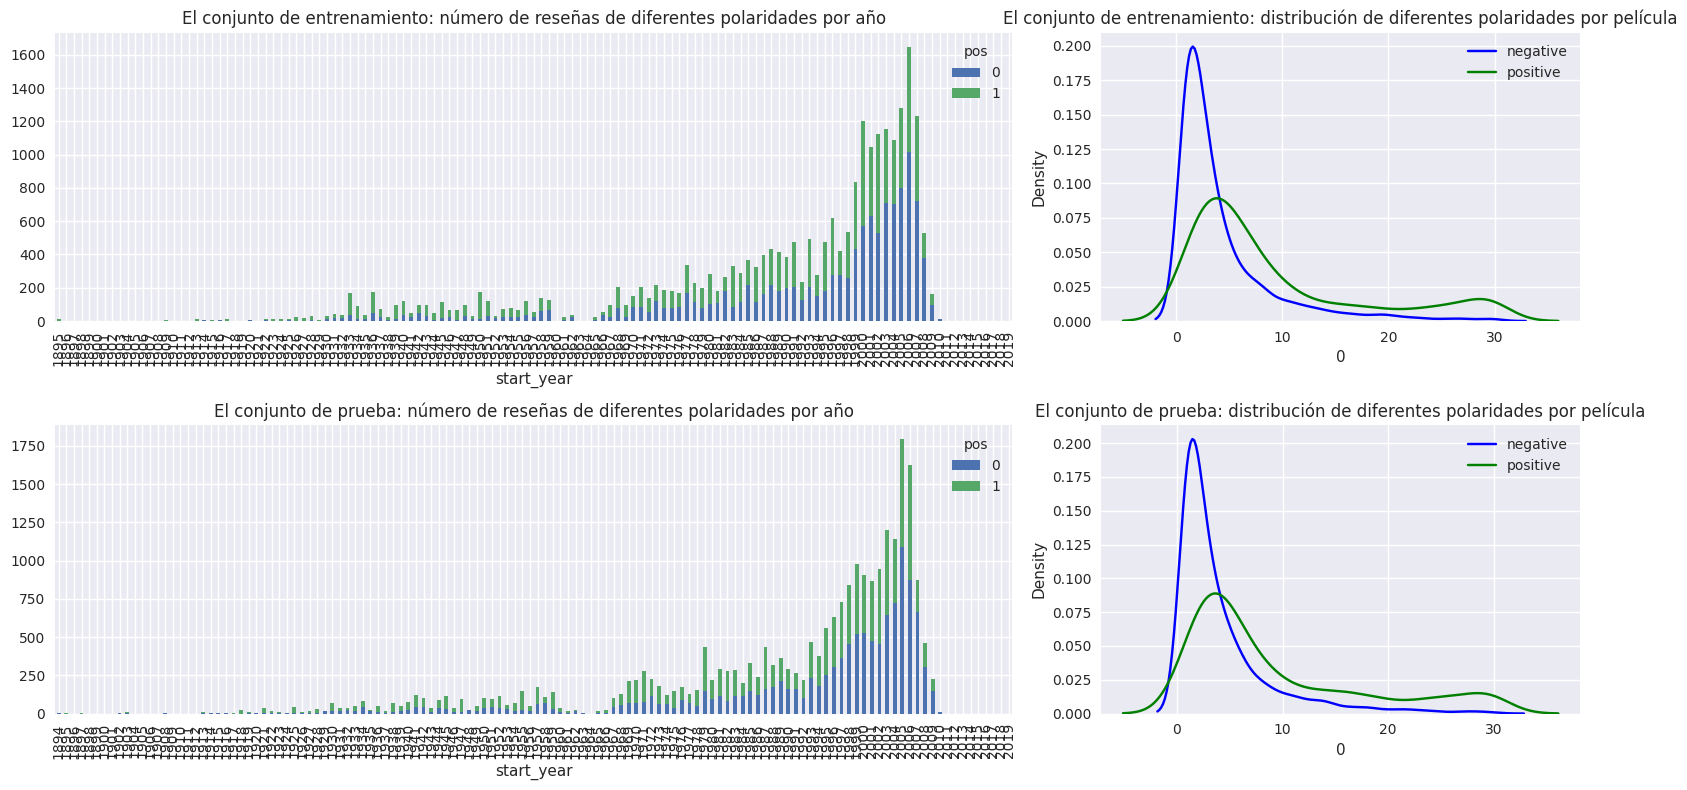

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Vemos el número de reseñas positivas y negativas a lo largo de los años y la tendencía de las mismas. siendo las negativas un poco más. 

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Preprocesamiento 

In [17]:
df_reviews = df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [18]:
df_reviews['review'].sample(10)

11298    Until I saw this special on HBO, I had never h...
39723    'The Merchant of Venice' is one of Shakespeare...
14828    30 years after the original film, "Goodbye, Mr...
29076    Mat Spirogolou's (Toby Malone) family know he ...
17831    ...and this movie easily exceeded my expectati...
10201    The first time I saw the poster, I was stunned...
45199    Wow...I can't believe just how bad ZOMBIE DOOM...
40630    The movie is a starter to what really happened...
4296     It may be the remake of 1987 Autumn's Tale aft...
9652     Dewaana as a film goes through the usual clich...
Name: review, dtype: object

In [19]:
df_reviews['review'] = df_reviews['review'].str.lower()
corpus = df_reviews['review']

Eliminamos duplicados y estandarizamos a minusculas. 

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [20]:
#Creamos una función que limpia y estandariza nuestros reviews
def clear_text(text):
    clean_text = re.sub(r'[^a-z\']' ," ",text) # Eliminamos carácteres que no sean letras o apòstrofes 
    clean_text = re.sub(r'br '," ", clean_text) #Eliminamos saltos de linea
    clean_text = re.sub(r'<br />'," ",clean_text) #quitar comando html de salto de línea
    clean_text = re.sub(r'span '," ", clean_text) #Eliminamos comando html de bloque
    
     #eliminaremos letras repetidas en palabras más de 3 veces consecutivas, cosa que pasa en las reseñas con el fin de enfatizar
    letras = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    for letra in letras:
        patron = "{}".format(letra)+"{3,}"
        clean_text = re.sub(patron, letra, clean_text)
    clean_text = " ".join(clean_text.split())
    
    return clean_text

In [21]:
#Aplicamos nuestra función
corpus = corpus.apply(clear_text)
corpus.sample(10)

35071    i thought watching employment videos on corpor...
23755    everyone in a while disney makes one of thoes ...
4987     pretentious horror film that looks like a soap...
11408    how can there be that many corrupt cops withou...
39042    i absolutely love this game to death ever sinc...
44172    two years after this movie was made the juror ...
14269    flynn known mostly for his swashbuckling roles...
47187    notice i have given this star if the option be...
6912     i saw this movie last night at the phila film ...
4431     okay first of i hate commenting on this thing ...
Name: review, dtype: object

In [22]:
#Añadimos nuestro resultado en una nueva columna al dt
df_reviews['review_norm'] = corpus
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
25050,tt0462570,movie,On Probation,Tiempo de valientes,2005,\N,112,0,"Action,Comedy,Crime",7.6,5668,this movie is damian szifrón's second immersio...,9,pos,1,train,2904,this movie is damian szifr n's second immersio...
32923,tt0120848,movie,Such a Long Journey,Such a Long Journey,1998,\N,113,0,Drama,6.8,442,i saw this film at the taos film festival last...,10,pos,1,train,6170,i saw this film at the taos film festival last...
18157,tt0141369,movie,Inspector Gadget,Inspector Gadget,1999,\N,78,0,"Action,Adventure,Comedy",4.1,44333,"why?!! this was an insipid, uninspired and emb...",1,neg,0,train,7199,why this was an insipid uninspired and embarra...
18197,tt0332658,movie,Intermission,Intermission,2003,\N,105,0,"Comedy,Crime,Drama",6.8,15023,"if you loved ""pulp fiction"" and like hand held...",4,neg,0,train,10973,if you loved pulp fiction and like hand held c...
43719,tt0160986,movie,Time at the Top,Time at the Top,1999,\N,96,0,"Family,Sci-Fi",6.0,552,a fascinating look at the relationship of a si...,10,pos,1,train,6818,a fascinating look at the relationship of a si...


In [23]:
#Eliminamos columnas innecesarias 
df_reviews = df_reviews.drop(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year', 'end_year', 'runtime_minutes', 'is_adult', 'average_rating', 'genres', 'votes', 'review', 'sp', 'idx'], axis=1)
df_reviews

,rating,pos,ds_part,review_norm
0,1,0,train,the pakage implies that warren beatty and gold...
1,1,0,train,how the hell did they get this made presenting...
2,3,0,test,there is no real story the film seems more lik...
3,7,1,test,um a serious film about troubled teens in sing...
4,9,1,test,i'm totally agree with garryjohal from singapo...
...,...,...,...,...
47326,10,1,test,this is another of my favorite columbos it spo...
47327,4,0,test,talk about being boring i got this expecting a...
47328,8,1,test,i never thought i'd say this about a biopic bu...
47329,9,1,test,spirit and chaos is an artistic biopic of miya...


Ya tenemos nuestro dataframe con una columna con los valores estandarizados y removimos columnas innecesarias 

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [24]:
lemmatizer  = WordNetLemmatizer()
#Creamos una función que tokenice y lematice usando nlkt 

def nltk_proccesing(text):
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return " ".join(lemmas)

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Creamos una función que tokenice y lematice usando spacy
def spacy_proccesing(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    return " ".join(lemmas)

In [26]:
#Agregamos una columna con el lematizado de nltk
df_reviews['nltk_norm'] = df_reviews['review_norm'].apply(nltk_proccesing)

In [27]:
#Agregamos una columna con el lematizado de spacy
df_reviews['spacy_norm'] = df_reviews['review_norm'].apply(spacy_proccesing)

In [28]:
df_reviews.sample(10)

,rating,pos,ds_part,review_norm,nltk_norm,spacy_norm
33763,4,0,test,a pretentious but to varying degrees watchable...,a pretentious but to varying degree watchable ...,a pretentious but to vary degree watchable col...
41672,10,1,train,i have lost count of just how many times i hav...,i have lost count of just how many time i have...,I have lose count of just how many time I have...
8267,4,0,train,creepshow had a lot of potential they just did...,creepshow had a lot of potential they just did...,creepshow have a lot of potential they just do...
44263,2,0,train,i like brad pitt enormously he is an actor wit...,i like brad pitt enormously he is an actor wit...,I like brad pitt enormously he be an actor wit...
39073,1,0,test,all things old are new again erika e is on cel...,all thing old are new again erika e is on cele...,all thing old be new again erika e be on celeb...
7121,2,0,train,this extremely low budget movie is compared to...,this extremely low budget movie is compared to...,this extremely low budget movie be compare to ...
34666,10,1,train,i was really impressed with this film the writ...,i wa really impressed with this film the writi...,I be really impressed with this film the writi...
21560,8,1,train,as other reviewers have noted this is an unjus...,a other reviewer have noted this is an unjustl...,as other reviewer have note this be an unjustl...
38458,7,1,test,the story is quite slow at the beginning excep...,the story is quite slow at the beginning excep...,the story be quite slow at the beginning excep...
32900,10,1,test,i have seen a number of horror movies to know ...,i have seen a number of horror movie to know t...,I have see a number of horror movie to know th...


In [29]:
#Agrupemos por valores de entrenamiento y de validación
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Guardemos nuestros features
df_reviews_nltk_train_feat = df_reviews_train.drop(columns={'review_norm','spacy_norm','pos'})
df_reviews_spacy_train_feat = df_reviews_train.drop(columns={'review_norm','nltk_norm','pos'})

#Guardemos nuestro corpus para entrenamiento y validación
nltk_train_corpus = df_reviews_train['nltk_norm']
nltk_test_corpus = df_reviews_test['nltk_norm']

spacy_train_corpus = df_reviews_train['spacy_norm']
spacy_test_corpus = df_reviews_test['spacy_norm']

#Guardemos nuestro objetivo
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 6)
(23533, 6)


Ya tenemos nuestros datos lematizados usando  nltk y spacy. Separamos nuestros features y nuestros objetivos para el modelaje. 

## Trabajar con modelos

In [30]:
#inicializamos nuestro contador 
count_tf_idf= TfidfVectorizer()

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


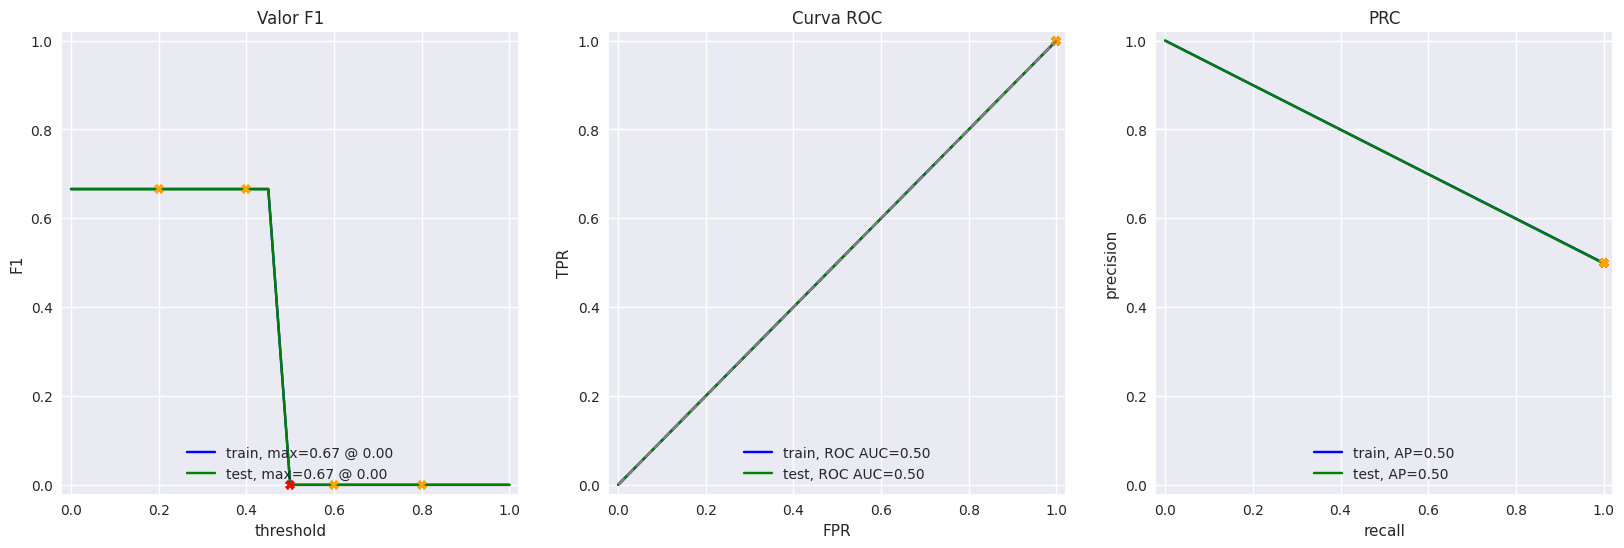

In [31]:
#Ejecutamos el método fit_transform que nos permitirá calcular la TF-IDF para el corpus 
features1_train = count_tf_idf.fit_transform(nltk_train_corpus)#extraemos caracteristicas para el entrenamiento 
features1_test = count_tf_idf.transform(nltk_test_corpus)#transformamos el corpus de validación

model_0 = DummyClassifier()
model_0.fit(features1_train, train_target) # inicializar el modelo de regresión logística y ajustarlo
pred_test_0 = model_0.predict(features1_test) # obtener predicciones para la parte de prueba de los datos

evaluate_model(model_0, features1_train, train_target, features1_test, test_target)

El modelo no parece tener un buen desempeño, predice con un 50% en todos las métricas.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [32]:
stop_words = nltk.corpus.stopwords.words('english')
m1_tf_idf= TfidfVectorizer(stop_words=stop_words)

#Ejecutamos el método fit_transform que nos permitirá calcular la TF-IDF para el corpus
features2_train = m1_tf_idf.fit_transform(nltk_train_corpus)#extraemos caracteristicas para el entrenamiento 
features2_test = m1_tf_idf.transform(nltk_test_corpus)#transformamos el corpus de validación

model_1 = LogisticRegression(random_state=123 ,solver='liblinear')
model_1.fit(features2_train, train_target) # inicializar el modelo de regresión logística y ajustarlo
pred_test_1 = model_1.predict(features2_test) # obtener predicciones para la parte de prueba de los datos

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


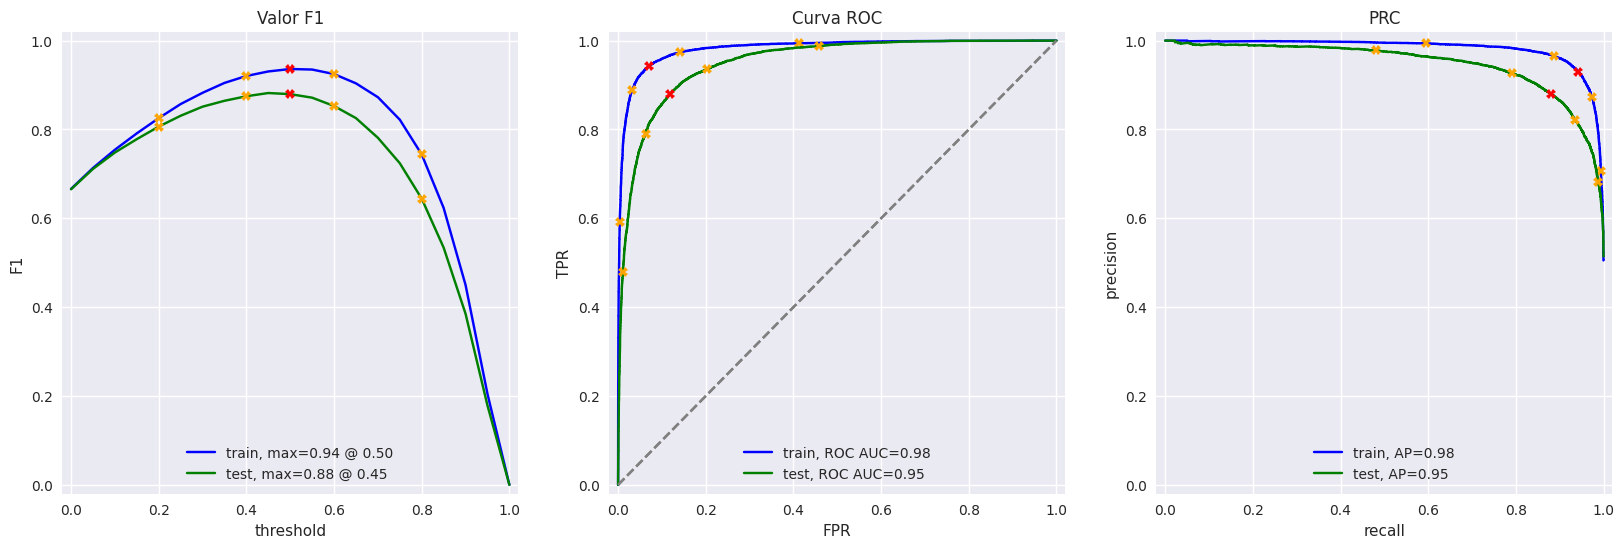

In [33]:
evaluate_model(model_1, features2_train, train_target, features2_test, test_target)

El modelo cumple con un F1 de al menos 0.85 y se logra el objetivo. Vemos que se acerca a los objetivos reales. 

### Modelo 3 - spaCy, TF-IDF y LR

In [34]:
m3_tf_idf= TfidfVectorizer(stop_words=stop_words)

#Ejecutamos el método fit_transform que nos permitirá calcular la TF-IDF para el corpus
features3_train = m3_tf_idf.fit_transform(spacy_train_corpus)#extraemos caracteristicas para el entrenamiento 
features3_test = m3_tf_idf.transform(spacy_test_corpus)#transformamos el corpus de validación

model_3 = LogisticRegression(random_state=123 ,solver='liblinear')
model_3.fit(features3_train, train_target) # inicializar el modelo de regresión logística y ajustarlo
pred_test_1 = model_3.predict(features3_test) # obtener predicciones para la parte de prueba de los datos

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


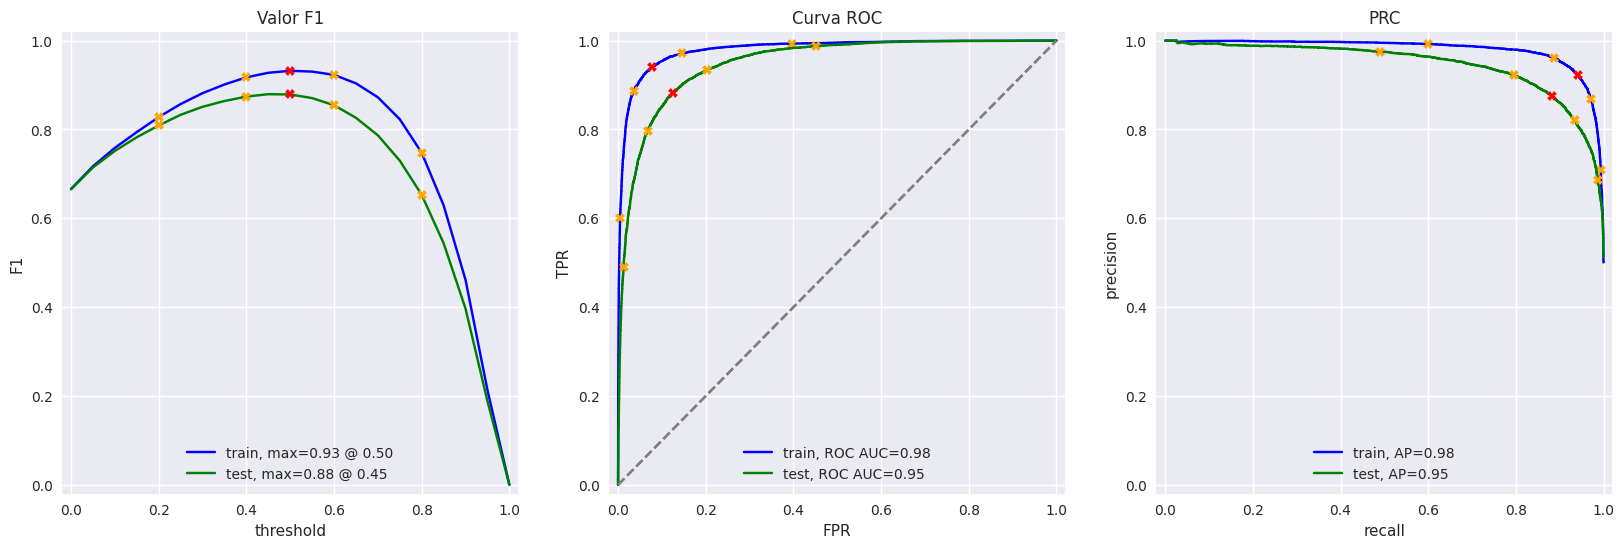

In [35]:
evaluate_model(model_3, features3_train, train_target, features3_test, test_target)

El model cumple con la métrica deseada de 0.85 en F1. al igual que el el modelo pasado se acerca mucho a los objetivos reales. 

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [36]:
m4_tf_idf= TfidfVectorizer(stop_words=stop_words)

#Ejecutamos el método fit_transform que nos permitirá calcular la TF-IDF para el corpus
features4_train = m4_tf_idf.fit_transform(spacy_train_corpus)#extraemos caracteristicas para el entrenamiento 
features4_test = m4_tf_idf.transform(spacy_test_corpus)#transformamos el corpus de validación

model_4 = LGBMClassifier()
model_4.fit(features3_train, train_target) # inicializar el modelo de regresión logística y ajustarlo
pred_test_1 = model_4.predict(features3_test) # obtener predicciones para la parte de prueba de los datos

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


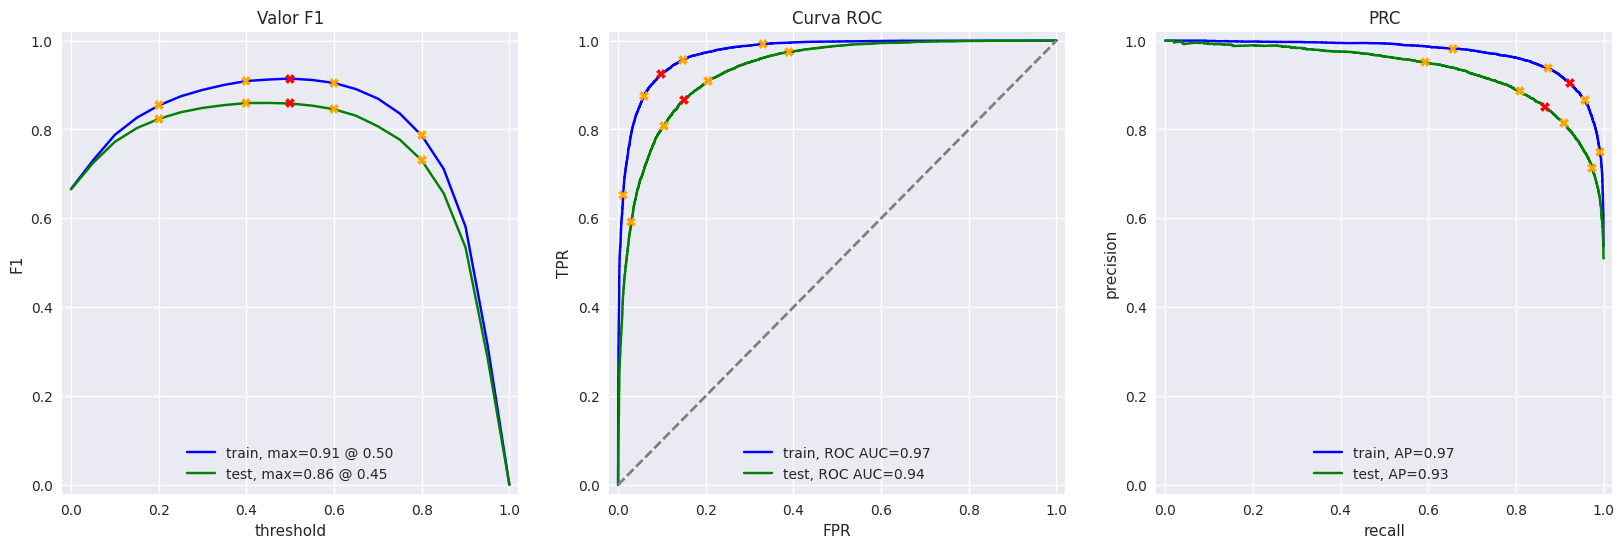

In [37]:
evaluate_model(model_4, features4_train, train_target, features4_test, test_target)

Este modelo tambien cumple con la métrica solicitada y aparenta estar más cerca entre las predicciones y los resultados reales. 

###  Modelo 9 - BERT

In [38]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    min_tokenized_text_length = 1e7  # Comienza con un valor grande
    max_tokenized_text_length = 0
    
    #Iteramos a través de cada texto
    for text in texts:
        #suprimimos las advertencias de salidas prolongadas 
        logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)
        #Tokenizamos usando BERT
        ids = tokenizer.encode(text, add_special_tokens=True,truncation=True,
        max_length=max_length)
        
        #Calculamos y actualizamos las longitudes minimas y máximas de texto tokenizado
        ids_len = len(ids)
        if ids_len < min_tokenized_text_length:
            min_tokenized_text_length = ids_len
            
        elif ids_len > max_tokenized_text_length:
            max_tokenized_text_length = ids_len
            
        n = 512 # Fijamos un limite de la secuencia 
        
        padded = np.array(ids[:n] + [0]*(n - len(ids))) #Rellenamos los ID de los tokens hasta max_length con 0
        
        attention_mask = np.where(padded != 0, 1, 0) #Creamos una máscara ..1 para tokens reales y 0 para tokens de relleno.
        
        ids_list.append(padded) #Agregamos los id's acolchados 
        
        attention_mask_list.append(attention_mask) #Agregamos las máscaras de atención 
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
         
        # unión de vectores de ids (de tokens) a un tensor   
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # unión de vectores de máscaras de atención a un tensor
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)])
        
        #Indicamos que no necesitamos gradientes     
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        # convierte elementos de tensor a numpy.array con la función numpy() 
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy()) 
        
    return np.concatenate(embeddings)

In [40]:
#La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:50])

Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_1368/1144249433.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [41]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:50])

Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(test_features_9.shape)
print(train_target.shape)

(23796,)
(50, 768)
(50, 768)
(23796,)


In [43]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Modelos de Regresion Logística con Bert

In [44]:
train_target_bert = df_reviews_train['pos'][:50]
test_target_bert = df_reviews_test['pos'][:50]

In [45]:
model_9 = LogisticRegression(random_state=123, solver='liblinear')
model_9.fit(train_features_9,train_target_bert)
model_9_pred = model_9.predict(test_features_9)

          train  test
Accuracy    1.0  0.74
F1          1.0  0.38
APS         1.0  0.52
ROC AUC     1.0  0.62


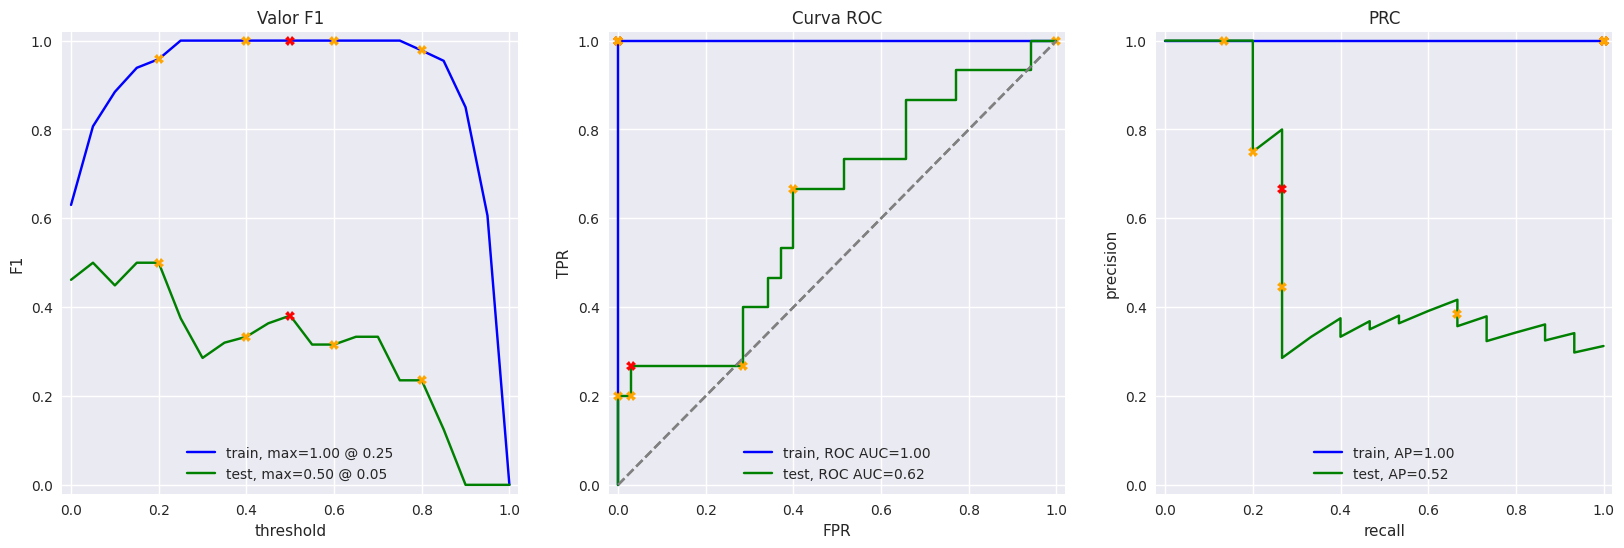

In [46]:
evaluate_model(model_9, train_features_9, train_target_bert, test_features_9, test_target_bert)

Observamos que las predicciones para el set de validación no alcanzan el umbral deseado y podemos ver la misma tendencia a la baja en todas las metricas

En general estoy satisfechos con los modelos. Cumplen con el objetivo de la metrica deseada de 0,85 del valor F1. con excepción del modelo BERT y el Dummy. 

## Mis reseñas

In [47]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""


my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",ell was bored and felt asleep in the middle of...
2,I was really fascinated with the movie,was really fascinated with the movie
3,Even the actors looked really old and disinter...,ven the actors looked really old and disintere...
4,I didn't expect the reboot to be so good! Writ...,didn't expect the reboot to be so good riters ...
5,"The movie had its upsides and downsides, but I...",he movie had its upsides and downsides but fee...
6,What a rotten attempt at a comedy. Not a singl...,hat a rotten attempt at a comedy ot a single j...
7,Launching on Netflix was a brave move & I real...,aunching on etflix was a brave move really app...


### Modelo 1

In [48]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(m1_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  did not simply like it not my kind of movie
0.07:  ell was bored and felt asleep in the middle of the movie
0.58:  was really fascinated with the movie
0.28:  ven the actors looked really old and disinterested and they got paid to be in the movie hat a soulle
0.37:  didn't expect the reboot to be so good riters really cared about the source material
0.49:  he movie had its upsides and downsides but feel like overall it's a decent flick could see myself go
0.11:  hat a rotten attempt at a comedy ot a single joke lands everyone acts annoying and loud even kids wo
0.92:  aunching on etflix was a brave move really appreciate being able to binge on episode after episode o


### Modelo 3

In [49]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(m3_tf_idf.transform(texts.apply(lambda x: nltk_proccesing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  did not simply like it not my kind of movie
0.15:  ell was bored and felt asleep in the middle of the movie
0.49:  was really fascinated with the movie
0.41:  ven the actors looked really old and disinterested and they got paid to be in the movie hat a soulle
0.45:  didn't expect the reboot to be so good riters really cared about the source material
0.52:  he movie had its upsides and downsides but feel like overall it's a decent flick could see myself go
0.05:  hat a rotten attempt at a comedy ot a single joke lands everyone acts annoying and loud even kids wo
0.93:  aunching on etflix was a brave move really appreciate being able to binge on episode after episode o


### Modelo 4

In [50]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = m4_tf_idf
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: spacy_proccesing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  did not simply like it not my kind of movie
0.32:  ell was bored and felt asleep in the middle of the movie
0.60:  was really fascinated with the movie
0.45:  ven the actors looked really old and disinterested and they got paid to be in the movie hat a soulle
0.73:  didn't expect the reboot to be so good riters really cared about the source material
0.73:  he movie had its upsides and downsides but feel like overall it's a decent flick could see myself go
0.26:  hat a rotten attempt at a comedy ot a single joke lands everyone acts annoying and loud even kids wo
0.79:  aunching on etflix was a brave move really appreciate being able to binge on episode after episode o


### Modelo 9

In [51]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.03:  did not simply like it not my kind of movie
0.05:  ell was bored and felt asleep in the middle of the movie
0.06:  was really fascinated with the movie
0.06:  ven the actors looked really old and disinterested and they got paid to be in the movie hat a soulle
0.01:  didn't expect the reboot to be so good riters really cared about the source material
0.13:  he movie had its upsides and downsides but feel like overall it's a decent flick could see myself go
0.01:  hat a rotten attempt at a comedy ot a single joke lands everyone acts annoying and loud even kids wo
0.21:  aunching on etflix was a brave move really appreciate being able to binge on episode after episode o


Despues de realizar nuevas predicciones con nuevas reseñas, probamos nuestros 4 modelo. y vemos similitudes entre las predicciones. Aunque el modelo 4 es el que desde mi punto de vista predice mejor. 

## Conclusiones

Realizamos un análisis y no encontramos grandes problemas con los datos. Procesamos los datos y estandarizamos dejando unicamente las palabras y las apostrofes. 

Lematizamos usando nltk y spacy y añadimos los valores lematizados de vuelta al dt.

Realizamos 5 modelos: Uno constante usando un dummyclassifier, uno de regresión lineal con lematizado nltk, uno de regresión lineal con lematizado spacy, otro usando lgbclassifier con un lematizado spacy y por último uno usando BERT. 

Por útlimo validamos nuestros modelos con nuevas reseñas y vemos que BERT es el modelo con el pero despempeño para predecir y desde mi punto de vista el modelo lgbclassifier es el que tiene una predicción más acertada puntuando mejor cuando una reseña es negativa y/o positiva. Sin embargo no quiere decir que los otros 2 sean malos modelos, solo creo que lgb es más acertado. 

Podemos observar la complejidad que requiere este tipo de predicciones. 